In [1]:
from pyspark.sql import SparkSession, functions as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = (
    SparkSession.builder.appName("Preprocessing_Yellow")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '3g')   
    .config('spark.executor.memory', '4g')  
    .config('spark.executor.instances', '2')  
    .config('spark.executor.cores', '2')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/10/02 22:33:31 WARN Utils: Your hostname, LAPTOP-RELH58H1 resolves to a loopback address: 127.0.1.1; using 172.19.22.4 instead (on interface eth0)
23/10/02 22:33:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/02 22:33:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
joined = spark.read.parquet("../../../data/curated/removed_outliers.parquet")

In [4]:
joined.show()

23/10/02 22:33:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+--------------------+-------------+------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+------------------+------------------+--------------------+---------------------------------+--------------------+------------------+
|merchant_abn|                name|revenue_level|         take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_of_order|average_spend_per_consumer|a

In [5]:
joined.select("average_cost_of_order").describe()

summary,average_cost_of_order
count,3965
mean,966.2920760933197
stddev,2205.253358871387
min,7.579026146267524
max,28754.635714285712


In [6]:
joined.select("number_of_unique_consumers").describe()

summary,number_of_unique_consumers
count,3965
mean,1717.6534678436317
stddev,3254.9274012569444
min,4
max,20115


In [7]:
joined.select("number_of_repeat_consumers").describe()

summary,number_of_repeat_consumers
count,3965
mean,468.66027742749054
stddev,1937.7782868661402
min,0
max,20113


In [8]:
joined.select("number_of_postcodes").describe()

summary,number_of_postcodes
count,3965
mean,739.2691046658259
stddev,838.1174200278368
min,3
max,2639


In [9]:
joined_pd = joined.toPandas()

In [10]:
joined_pd.columns

Index(['merchant_abn', 'name', 'revenue_level', 'take_rate',
       'average_merchant_fraud_probability', 'number_of_unique_consumers',
       'average_consumer_fraud_probability', 'number_of_repeat_consumers',
       'average_repeat_transactions_per_consumer', 'number_of_orders',
       'average_cost_of_order', 'average_spend_per_consumer',
       'average_monthly_diff_consumers', 'consumer_diff_over_period',
       'average_growth_consumers', 'merchant_revenue_rounded',
       'first_recorded_transaction', 'last_recorded_transaction',
       'transcation_period_months', 'number_of_postcodes',
       'avg_total_weekly_personal_income', 'avg_total_weekly_fam_income',
       'avg_median_age', 'avg_household_size', 'postcode_reach',
       'avg_num_of_consumers_per_postcode', 'segment', 'bnpl_maximum_gain'],
      dtype='object')

In [11]:
numerical_columns = joined_pd[['take_rate',
       'average_merchant_fraud_probability', 'number_of_unique_consumers',
       'average_consumer_fraud_probability', 'number_of_repeat_consumers',
       'number_of_orders', 'average_cost_of_order', 'number_of_postcodes',
       'avg_total_weekly_personal_income', 'avg_total_weekly_fam_income',
       'avg_median_age', 'avg_num_of_consumers_per_postcode']]

In [12]:
numerical_columns.corr()

,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,number_of_orders,average_cost_of_order,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_num_of_consumers_per_postcode
take_rate,1.000000,-0.004505,0.039364,-0.057896,0.029178,0.024979,-0.063362,0.051224,-0.006922,-0.002601,0.002598,0.023041
average_merchant_fraud_probability,-0.004505,1.000000,-0.005603,0.308368,0.008336,0.000686,0.302147,-0.022873,-0.016670,-0.005926,0.012915,0.001691
number_of_unique_consumers,0.039364,-0.005603,1.000000,-0.144273,0.860697,0.714180,-0.180890,0.845176,0.008346,0.010363,-0.002720,0.679941
average_consumer_fraud_probability,-0.057896,0.308368,-0.144273,1.000000,-0.070213,-0.067671,0.911378,-0.225068,-0.013553,-0.017998,0.020804,-0.058409
number_of_repeat_consumers,0.029178,0.008336,0.860697,-0.070213,1.000000,0.891224,-0.093431,0.514505,0.003661,0.004831,-0.001022,0.880073
number_of_orders,0.024979,0.000686,0.714180,-0.067671,0.891224,1.000000,-0.088319,0.444271,0.003770,0.004847,-0.001338,0.998699
average_cost_of_order,-0.063362,0.302147,-0.180890,0.911378,-0.093431,-0.088319,1.000000,-0.268882,-0.032807,-0.053168,0.031012,-0.077164
number_of_postcodes,0.051224,-0.022873,0.845176,-0.225068,0.514505,0.444271,-0.268882,1.000000,0.015366,0.017776,-0.005614,0.399428
avg_total_weekly_personal_income,-0.006922,-0.016670,0.008346,-0.013553,0.003661,0.003770,-0.032807,0.015366,1.000000,0.853739,-0.498958,0.003184
avg_total_weekly_fam_income,-0.002601,-0.005926,0.010363,-0.017998,0.004831,0.004847,-0.053168,0.017776,0.853739,1.000000,-0.451460,0.004139


<Axes: >

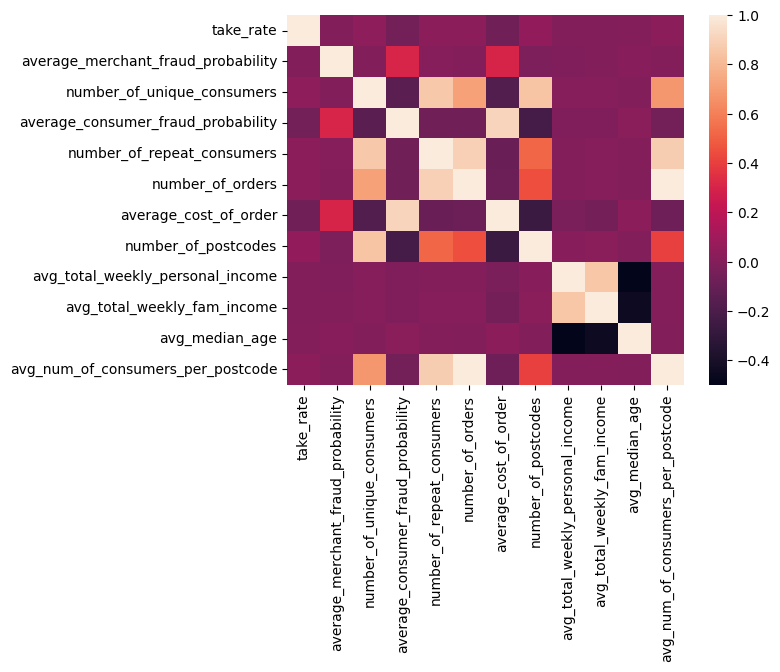

In [13]:
sns.heatmap(numerical_columns.corr())

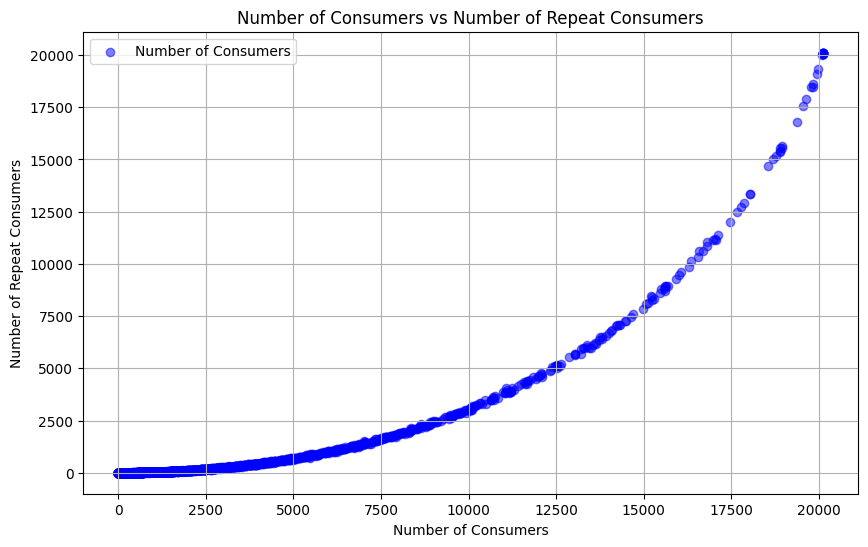

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(joined_pd['number_of_unique_consumers'], joined_pd['number_of_repeat_consumers'], color='blue', label='Number of Consumers', alpha=0.5)
plt.title('Number of Consumers vs Number of Repeat Consumers')
plt.xlabel('Number of Consumers')
plt.ylabel('Number of Repeat Consumers')
plt.legend()
plt.grid(True)

In [15]:
joined.select("number_of_orders").describe()

summary,number_of_orders
count,3965
mean,2868.24842370744
stddev,11902.000659526533
min,4
max,241547


In [16]:
spark.stop()